<a href="https://colab.research.google.com/github/Sharon-Faith/rango-proj/blob/modelling/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [ ]:

df = pd.read_csv('clean-heart')

In [ ]:
# Encoding the categorical columns
# 
cols=['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']
le = LabelEncoder()
df_encoded=df.copy()
for col in cols:
  df_encoded[col] = le.fit_transform(df_encoded[col])

In [ ]:
# Confirming the changes

df_encoded.tail()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
741,45,1,3,110,264,0,1,132,0,1.2,1,1
742,68,1,0,144,193,1,1,141,0,3.4,1,1
743,57,1,0,130,131,0,1,115,1,1.2,1,1
744,57,0,1,130,236,0,0,174,0,0.0,1,1
745,38,1,2,138,175,0,1,173,0,0.0,2,0


#**MODELLING**

In [ ]:
#importing required libraries
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
#target column - heart disease
#there is a class imbalance but only a slight one
df.heartdisease.value_counts()

0    390
1    356
Name: heartdisease, dtype: int64

In [ ]:
accuracies = []

## 1.Random Forest Approach

In [ ]:


# Split the independent and dependent variables

y = df_encoded['heartdisease'].values


X = df_encoded.drop(columns='heartdisease').values

#X column names
x_cols = df.drop(columns='heartdisease').columns


# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

[[98 18]
 [12 96]]


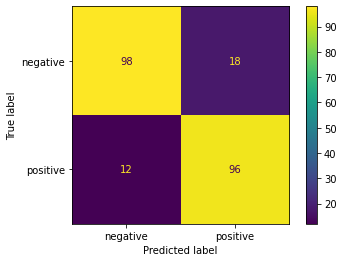

Recall:  0.889
F-1:  0.865
Accuracy:  0.866


In [ ]:
#Fitting the model

forest = RandomForestClassifier(n_estimators = 100, random_state=0, min_samples_split = 20, max_depth=5)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)


from sklearn import metrics

#evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('First random forest: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)



In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}



The main interest is detecting presence of heart disease (class 1), in which case false negatives are more detrimental than false positives. Recall is therefore the most key metric to consider, and we should attempt to optimize our model for recall.

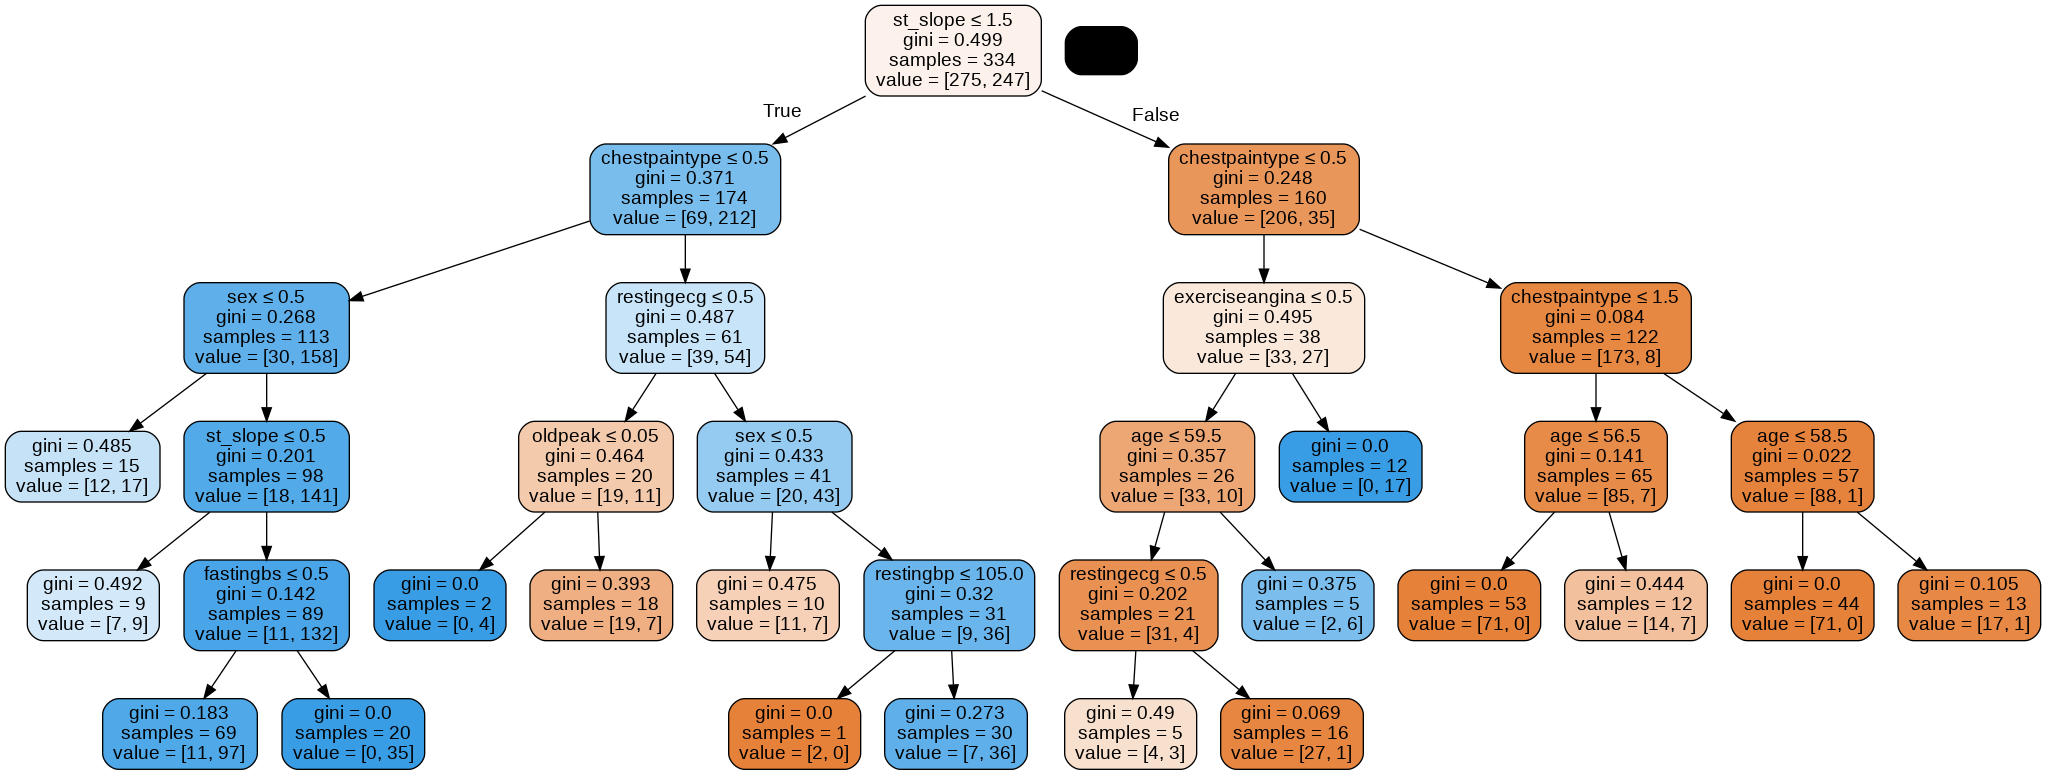

In [ ]:
#visualising the second tree of model above
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# pick a specific tree from the forest
tree = forest.estimators_[1]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = x_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('forest.png')
Image(graph.create_png())

In [ ]:
#using grid search to tune hyperparameters
#finding best parameter values from range below
parameters = {'n_estimators': np.arange(50, 500, 50),
              'min_samples_split': np.arange(5, 30, 5),
              'max_depth': np.arange(2,7)}
rforest = RandomForestClassifier(random_state=0)
#finding values
search = GridSearchCV(estimator=rforest,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'max_depth': 6, 'min_samples_split': 15, 'n_estimators': 450}


[[99 17]
 [12 96]]


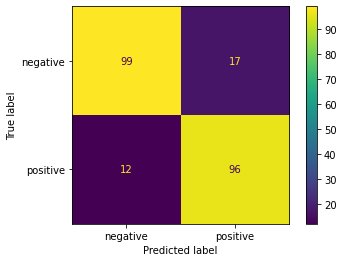

Recall:  0.889
F-1:  0.869
Accuracy:  0.871


In [ ]:
#creating model with hyperparameter values observed above and fitting the model
forest = RandomForestClassifier(n_estimators = 450, random_state=0, min_samples_split = 15, max_depth=6)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)

#evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()
recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('Random forest after tuning: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:

#interest is detecting presence of heart disease, where false negatives are more detrimental
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}



Although  F1 scores and accuracy are slightly higher, recall which is our main focus has not improved.

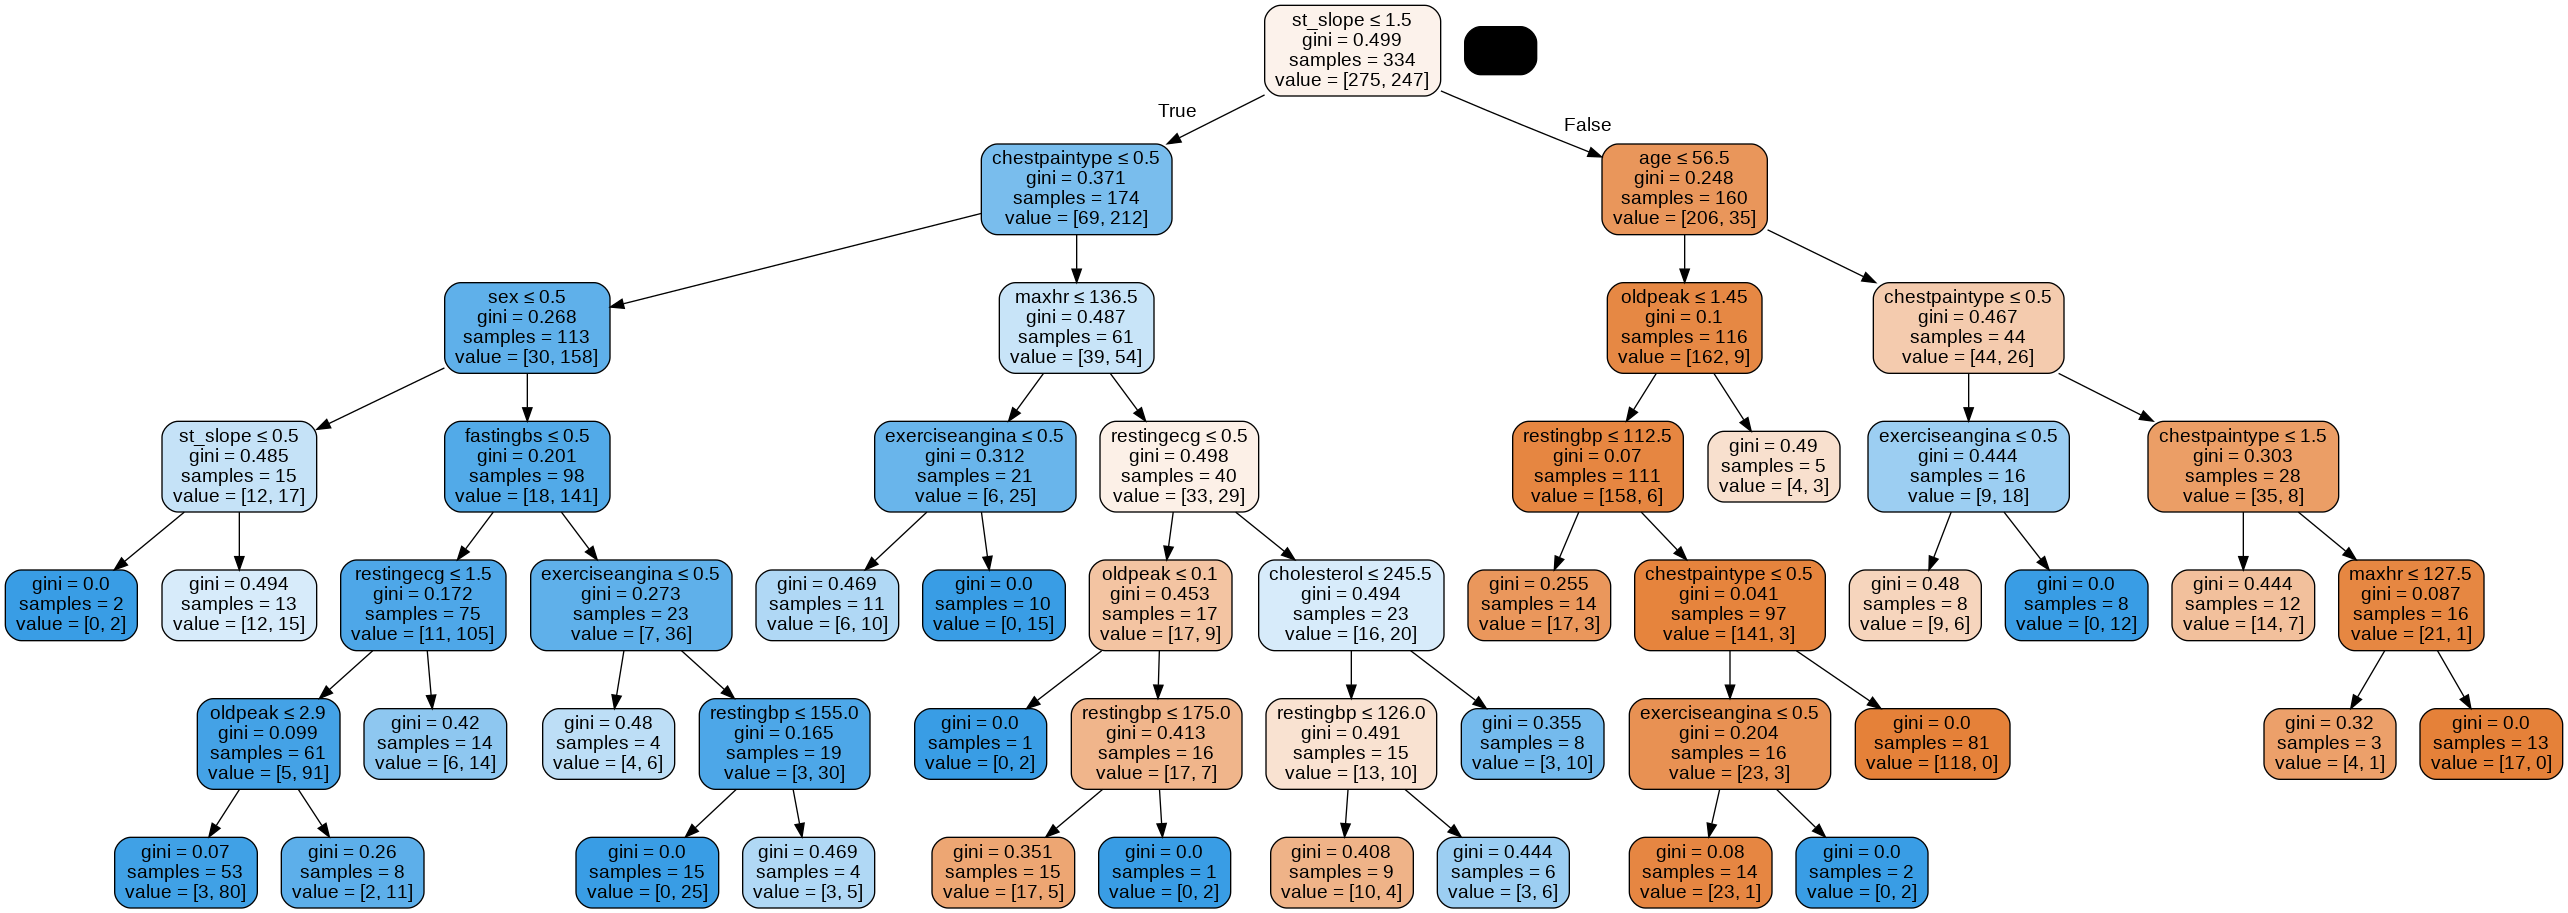

In [ ]:
#visualising the second tree of the fine-tuned hyperparameter model
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# pick a specific tree from the forest
tree = forest.estimators_[1]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = x_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('forest.png')
Image(graph.create_png())

## 2.Gradient Boosting Approach

[[95 21]
 [14 94]]


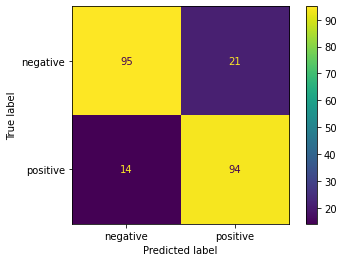

Recall:  0.87
F-1:  0.843
Accuracy:  0.844


In [ ]:
#fitting first gbc model 
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=0)
gbc = gbc.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = gbc.predict(X_test)

#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()
recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('First gradient boosting classifier(gbc): ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}



Before tuning the hyperparameters, it can be observed that the first gradient boosting classifier generally performs worse than the random forests.

In [ ]:
#using grid search to tune hyperparameters
#finding best parameter values from range below
parameters = {'n_estimators': np.arange(100, 500, 100),
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': np.arange(2,7)}
gdbc = GradientBoostingClassifier(random_state=0)
#finding values
search = GridSearchCV(estimator=gdbc,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


[[95 21]
 [10 98]]


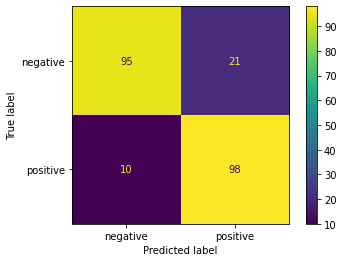

Recall:  0.907
F-1:  0.863
Accuracy:  0.862


In [ ]:
#creating a model with the tuned hyperparameters identified above and fitting the model
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=2, random_state=0)
gbc = gbc.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = gbc.predict(X_test)

#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()
recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('Gbc after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}



After tuning the hyperparameters, it can be observed that the best recall score so far is obtained. This is key, as we are trying to optimize the model for recall.

### Feature importance

Feature importance will be identified using the best tree-based model identified so far (gradient boosting classifier with tuned hyperparameters - 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300)

Variable: st_slope, Importance: 0.52
Variable: chestpaintype, Importance: 0.19
Variable: exerciseangina, Importance: 0.14
Variable: sex, Importance: 0.05
Variable: oldpeak, Importance: 0.04
Variable: restingbp, Importance: 0.02
Variable: maxhr, Importance: 0.02
Variable: age, Importance: 0.01
Variable: restingecg, Importance: 0.01
Variable: cholesterol, Importance: 0.0
Variable: fastingbs, Importance: 0.0


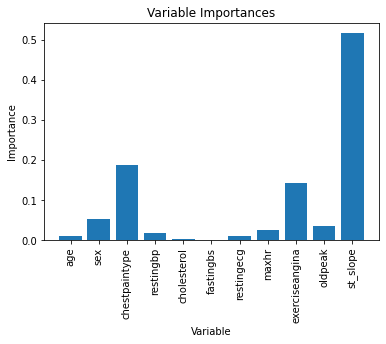

In [ ]:
# List of tuples with variable and importance using the gbc tuned model (the best recall)
importances = gbc.feature_importances_
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_cols, importances)]

#sorting the values in descending order
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Printing out the feature and importances 
for feat, signif in feature_importances:
  print(f'Variable: {feat}, Importance: {signif}') 

# Making a bar chart
plt.bar(x_cols, importances) 
# Tick labels for x axis
plt.xticks(rotation='vertical')

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
from sklearn.model_selection import train_test_split

# Split the independent and dependent variables

y = df_encoded['heartdisease'].values

#selecting top 3 most important features
X = df_encoded[['st_slope', 'chestpaintype', 'exerciseangina']].values

# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

[[ 88  28]
 [  8 100]]


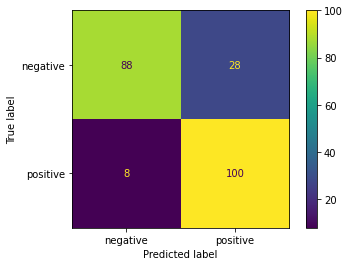

Recall:  0.926
F-1:  0.847
Accuracy:  0.839


In [ ]:
#creating a model with the tuned hyperparameters, and fitting the model with top 3 features selected above, 
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=2, random_state=0)
gbc = gbc.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = gbc.predict(X_test)

#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('Gbc after tuning hyperparams, using select features: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}



When using the tuned hyperparameters we obtained and the top three most important features ('st_slope', 'chestpaintype', 'exerciseangina'), the highest recall so far was obtained - 0.926. Although the f-1 and accuracy scores are slightly lower than some of the other tree-based models, optimizing recall was of more importance when it comes to detecting heart disease (but still having an acceptable f-1 score), so this is the best model for our case.

## 3.SVM Approach

After exploring random forests and gradient boosting classifiers, we want to test recall obtained when using support vector machines for classification.

The features will be scaled

#### Linear kernel

In [ ]:
#separating features and target
y = df_encoded['heartdisease']


X = df_encoded.drop(columns='heartdisease')

# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#X column names
x_cols = df.drop(columns='heartdisease').columns

#scaling the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[[101  15]
 [ 15  93]]


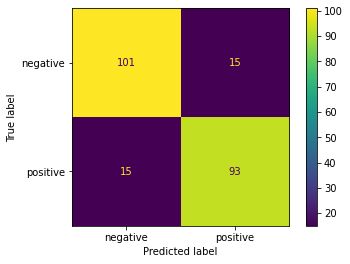

Recall:  0.861
F-1:  0.861
Accuracy:  0.866


In [ ]:
from sklearn.svm import SVC

# Fit the model. 
svc = SVC(kernel= 'linear')
model = svc.fit(X_train,y_train)

# making prediction
y_pred = model.predict(X_test)

#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM Linear kernel 1: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}



As can be observed, the recall of this model is still lower than the highest identified by gradient boosting.

In [ ]:
#tuning parameters

parameters = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
            }
svct = SVC(kernel= 'linear')
#finding values
search = GridSearchCV(estimator=svct,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'C': 0.1}


[[101  15]
 [ 15  93]]


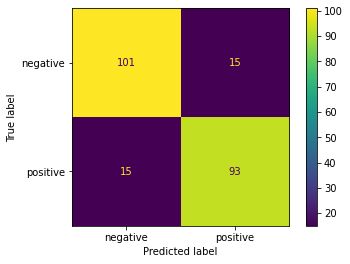

Recall:  0.861
F-1:  0.861
Accuracy:  0.866


In [ ]:
# Fit the model with tuned C parameter
svc = SVC(kernel= 'linear', C = 0.1)
model = svc.fit(X_train,y_train)

# making prediction
y_pred = model.predict(X_test)


#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM linear kernel after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}



Upon tuning C parameter, scores remain the same as before tuning. The recall therefore still lower than best identified by gradient boosting.

#### Polynomial kernel

[[102  14]
 [ 34  74]]


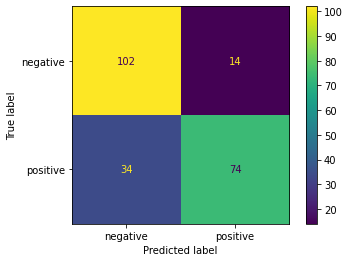

Recall:  0.685
F-1:  0.755
Accuracy:  0.786


In [ ]:
#polynomial kernel

# Building the model 
polyclassifier = SVC(kernel='poly',degree=2)
# Training the model using the training set
polyclassifier.fit(X_train, y_train)

# making prediction
y_pred = polyclassifier.predict(X_test)

#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM polynomial kernel 1: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}



The first polynomial kernel model has metric scores significantly lower than all other models so far.

In [ ]:
#tuning parameters

parameters = {'degree': np.arange(2,7)
            }
svct = SVC(kernel= 'poly')
#finding values
search = GridSearchCV(estimator=svct,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'degree': 3}


[[101  15]
 [ 21  87]]


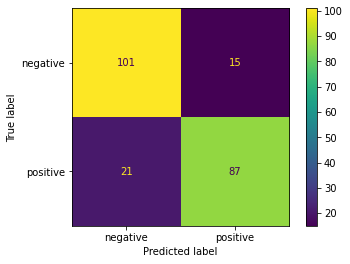

Recall:  0.806
F-1:  0.829
Accuracy:  0.839


In [ ]:
#Testing with a different degree hyperparameter value

# Building the model 
polyclassifier = SVC(kernel='poly',degree=3,gamma='auto')
# Training the model using the training set
polyclassifier.fit(X_train, y_train)

# making prediction
y_pred = polyclassifier.predict(X_test)
#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM polynomial kernel after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}



After tuning the degree hyperparameter, the polynomial kernel SVM performs much better than the first polynomial one, but the recall obtained (0.806) is still much lower than the best identified(0.926 - gradient boosting)

#### Sigmoid kernel

[[99 17]
 [17 91]]


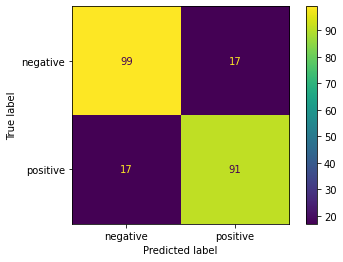

Recall:  0.843
F-1:  0.843
Accuracy:  0.848


In [ ]:
#sigmoidkernel

# Building the model 
sigclassifier = SVC(kernel='sigmoid')
# Training the model using the training set
sigclassifier.fit(X_train, y_train)

# making prediction
y_pred = sigclassifier.predict(X_test)
#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM sigmoid kernel 1: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}

SVM sigmoid kernel 1: 
{'Recall': 0.843, 'F-1': 0.843, 'Accuracy': 0.848}



The recall (0.843) obtained is lower than the best identified (0.926)

In [ ]:
#tuning parameters

parameters = {
              'C': [0.1, 1, 10, 100],
              
            }
svcs = SVC(kernel= 'sigmoid')
#finding values
search = GridSearchCV(estimator=svcs,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'C': 0.1}


[[103  13]
 [ 17  91]]


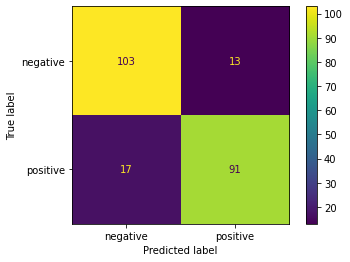

Recall:  0.843
F-1:  0.858
Accuracy:  0.866


In [ ]:
#sigmoidkernel

# Building the model 
sigclassifier = SVC(kernel='sigmoid', C=0.1)
# Training the model using the training set
sigclassifier.fit(X_train, y_train)

# making prediction
y_pred = sigclassifier.predict(X_test)
#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM sigmoid kernel after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}

SVM sigmoid kernel 1: 
{'Recall': 0.843, 'F-1': 0.843, 'Accuracy': 0.848}

SVM sigmoid kernel after tuning hyperparams: 
{'Recall': 0.843, 'F-1': 0.858, 'Accuracy': 0.866}



After tuning, the sigmoid kernel svm performs better than before tuning in terms of f-1 and accuracy, but recall which is our main metric of interest doesnt improve and is still lower (0.843) than the gradient boosting (0.926).

#### RBF kernel

[[98 18]
 [14 94]]


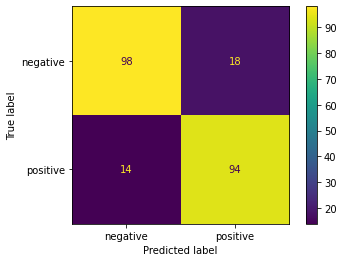

Recall:  0.87
F-1:  0.855
Accuracy:  0.857


In [ ]:
#rbf
#rbf kernel

# Building the model 
rbfclassifier = SVC(kernel='rbf')
# Training the model using the training set
rbfclassifier.fit(X_train, y_train)

# making prediction
y_pred = rbfclassifier.predict(X_test)
#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM rbf kernel 1: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}

SVM sigmoid kernel 1: 
{'Recall': 0.843, 'F-1': 0.843, 'Accuracy': 0.848}

SVM sigmoid kernel after tuning hyperparams: 
{'Recall': 0.843, 'F-1': 0.858, 'Accuracy': 0.866}

SVM rbf kernel 1: 
{'Recall': 0.87, 'F-1

The first rbf kernel model has a recall of 0.87, lower than that with gradient boosting (0.926)

In [ ]:
#tuning parameters

parameters = {
              'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10]
            }
svcr = SVC(kernel= 'rbf')
#finding values
search = GridSearchCV(estimator=svcr,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'C': 10, 'gamma': 1}


[[82 34]
 [10 98]]


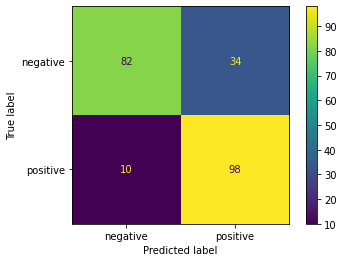

Recall:  0.907
F-1:  0.817
Accuracy:  0.804


In [ ]:
# Building the model 
rbfclassifier = SVC(kernel='rbf', gamma = 1, C=10)
# Training the model using the training set
rbfclassifier.fit(X_train, y_train)

# making prediction
y_pred = rbfclassifier.predict(X_test)
#Evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies.append(('SVM rbf kernel after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}

SVM sigmoid kernel 1: 
{'Recall': 0.843, 'F-1': 0.843, 'Accuracy': 0.848}

SVM sigmoid kernel after tuning hyperparams: 
{'Recall': 0.843, 'F-1': 0.858, 'Accuracy': 0.866}

SVM rbf kernel 1: 
{'Recall': 0.87, 'F-1

After tuning, recall using rbf kernel improves from 0.87 to 0.907, which is the best among the SVM models. However, this score is still lower than the 0.926 with gradient boosting.

## 4.KNN Approach

In [ ]:
accuracies2 = []

In [ ]:
#separating features and target
y = df_encoded['heartdisease']


X = df_encoded.drop(columns='heartdisease')

# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#X column names
x_cols = df.drop(columns='heartdisease').columns

#scaling the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[[98 18]
 [18 90]]


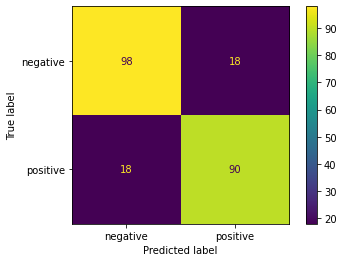

Recall:  0.833
F-1:  0.833
Accuracy:  0.839


In [ ]:
# Training and Predictions
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

#evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies2.append(('First knn: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)


Recall of 0.833 still lower than best identified so far (0.926-gradient boosting)

In [ ]:
#using grid search to tune hyperparameters
#finding best parameter values from range below
parameters = {'n_neighbors': np.arange(3, 15, 2),
              'metric': ['minkowski', 'euclidean','manhattan']}

knn = KNeighborsClassifier()
#finding values
search = GridSearchCV(estimator=knn,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'metric': 'manhattan', 'n_neighbors': 9}


[[100  16]
 [ 15  93]]


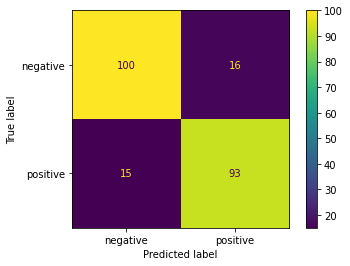

Recall:  0.861
F-1:  0.857
Accuracy:  0.862


In [ ]:
# Training and Predictions

classifier = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

#evaluating the model
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'positive'])

plt.show()

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracies2.append(('knn after tuning hyperparams: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))
print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

In [ ]:
for accuracy in accuracies2:
  print(accuracy[0])
  print(accuracy[1])
  print('')

First knn: 
{'Recall': 0.833, 'F-1': 0.833, 'Accuracy': 0.839}

knn after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.857, 'Accuracy': 0.862}



After tuning, the knn performs better than before tuning across all metrics, with recall rising from 0.833 to 0.861. This is however still lower than best identified - 0.926 recall gradient boosting.

## 5.Logistic regression Approach

In [ ]:
accuracieslog=[]

In [ ]:
#separating features and target
y = df_encoded['heartdisease']


X = df_encoded.drop(columns='heartdisease')

# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#X column names
x_cols = df.drop(columns='heartdisease').columns


In [ ]:
from sklearn.linear_model import LogisticRegression


#scaling the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#fitting logistic regression model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

#predicting class
y_pred = LogReg.predict(X_test)

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)
accuracieslog.append(('first logistic reg model: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))

print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

Recall:  0.861
F-1:  0.861
Accuracy:  0.866


Recall of 0.86 still lower than best identified - gradient boosting recall 0.926

In [ ]:
#using grid search to tune hyperparameters
#finding best parameter values from range below
parameters = {'C': [0.001,0.01,0.1,1,10,100]}
lreg = LogisticRegression()
#finding values
search = GridSearchCV(estimator=lreg,param_grid=parameters,scoring='recall')
search.fit(X_train,y_train)
print(search.best_params_)

{'C': 1}


C parameter value obtained by grid search is equivalent to the default used in the first logistic regression model so the results will be the same - Recall:  0.861, F-1:  0.861,Accuracy:  0.866. 


In [ ]:
#feature selection

#in gradient boosting, feature importances were identified,
#and the top 3 were chestpaintype, st slope and exercise angina.
#testing building a logistic regression model with these features only 

# Split the independent and dependent variables

y = df_encoded['heartdisease'].values

#selecting top 3 most important features
X = df_encoded[['st_slope', 'chestpaintype', 'exerciseangina']].values

# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#scaling the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#fitting logistic regression model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

#predicting class
y_pred = LogReg.predict(X_test)

recall = round(metrics.recall_score(y_test, y_pred), 3)
f1 = round(metrics.f1_score(y_test, y_pred), 3)
accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)

accuracieslog.append(('logistic reg model with select features: ', {
    'Recall': recall,
    'F-1': f1,
    'Accuracy': accuracy
}))

print('Recall: ', recall)
print('F-1: ', f1)
print('Accuracy: ', accuracy)

Recall:  0.87
F-1:  0.847
Accuracy:  0.848


In [ ]:
for accuracy in accuracieslog:
  print(accuracy[0])
  print(accuracy[1])
  print('')

first logistic reg model: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

logistic reg model with select features: 
{'Recall': 0.87, 'F-1': 0.847, 'Accuracy': 0.848}



using select features, recall improves slightly. This recall(0.87) is still lower than current benchmark (0.926-gradient boosting)

## 6.Modelling Summary

**MODELLING SUMMARY**

Our task was to build a model able to detect the presence of heart disease in an individual. In such a problem, prioritizing minimising the number of false negatives is more important than false positives, because the consequences of a false negative are more dire (eg death/worse prognosis). Therefore, in looking at the different evaluation metrics eg recall, accuracy etc, recall was the most important metric to optimize (higher the recall, lower the number of false negatives).

The models tested and optimised were built applying 5 types of classifiers:
* Random forests
* Gradient boosting classifier
* Support vector machines
* K-Nearest-Neighbors 
* Logistic regressors 

**1.Random forests**

* The first random forest model built had a recall of 0.889.
* After tuning the hyperparameter values, the model created had metrics such as f-1 and accuracy improve but recall which is our primary metric remained the same: 0.889 

**2.Gradient boosting classifier**
* The first gradient boosting classifier had a recall of 0.87.
* After tuning the hyperparameter values, the mode created had its recall improve to 0.907, which was higher than random forest’s 0.889. 
* Feature importances were then determined using the gradient boosting classifier above giving a recall of 0.907. The top 3 most important features in determining whether an individual would have heart disease or not were identified to be st_slope, chestpaintype and exerciseangina, in that order.
* A gradient boosting classifier using the tuned hyperparameters and training on the top 3 features identified above was then built. This model had a recall of 0.926, the best identified so far.

**3.SVM**

a) Linear kernel:

* First linear kernel model had a recall of  0.861. 
* After tuning hyperparameters the next model still didn’t improve. This recall was lower than the benchmark: 0.926 by gradient boosting.

b) Polynomial kernel:
* First polynomial kernel model had a recall of 0.685 which is quite low.
* After tuning hyperparameters, the next polynomial kernel model had a better recall of 0.806. However, this recall was lower than the benchmark: 0.926 by gradient boosting.

c) Sigmoid kernel:
* First sigmoid kernel model had recall of 0.843. 
* After tuning hyperparameters, the next model had the same recall even though other metrics eg f1 improved. However, this recall was lower than the benchmark: 0.926 by gradient boosting.

d) Radial Basis Function kernel:
* First rbf model had a recall of 0.87.
* After tuning hyperparameters, the next model’s recall improved to 0.907. However, this recall was lower than the benchmark: 0.926 by gradient boosting.

**4.KNN**
* First knn model had a recall of 0.833
* After tuning hyperparameters, next knn model had a better recall of 0.861. However, this recall was lower than the benchmark: 0.926 by gradient boosting.

**5.Logistic regression**
* First logistic regression model had a recall of 0.861.
* Next model was built with select features (the top 3 most important identified earlier  by gradient boosting-st_slope, chestpaintype, exerciseangina). This model had a better recall of 0.870. However, this recall was still lower than the benchmark: 0.926 by gradient boosting.

**Therefore, out of the various models evaluated, none outperformed the recall (0.926) of the gradient boosting classifier with these hyperparameters —n_estimators 300, learning_rate 0.01, max_depth 2— and trained on st_slope, chestpaintype and exerciseangina.**


In [ ]:
#scores for all models tested
lists = [accuracies, accuracies2, accuracieslog]

for y in lists:
  for x in y:
    print(x[0])
    print(x[1])
    print('')

First random forest: 
{'Recall': 0.889, 'F-1': 0.865, 'Accuracy': 0.866}

Random forest after tuning: 
{'Recall': 0.889, 'F-1': 0.869, 'Accuracy': 0.871}

First gradient boosting classifier(gbc): 
{'Recall': 0.87, 'F-1': 0.843, 'Accuracy': 0.844}

Gbc after tuning hyperparams: 
{'Recall': 0.907, 'F-1': 0.863, 'Accuracy': 0.862}

Gbc after tuning hyperparams, using select features: 
{'Recall': 0.926, 'F-1': 0.847, 'Accuracy': 0.839}

SVM Linear kernel 1: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM linear kernel after tuning hyperparams: 
{'Recall': 0.861, 'F-1': 0.861, 'Accuracy': 0.866}

SVM polynomial kernel 1: 
{'Recall': 0.685, 'F-1': 0.755, 'Accuracy': 0.786}

SVM polynomial kernel after tuning hyperparams: 
{'Recall': 0.806, 'F-1': 0.829, 'Accuracy': 0.839}

SVM sigmoid kernel 1: 
{'Recall': 0.843, 'F-1': 0.843, 'Accuracy': 0.848}

SVM sigmoid kernel after tuning hyperparams: 
{'Recall': 0.843, 'F-1': 0.858, 'Accuracy': 0.866}

SVM rbf kernel 1: 
{'Recall': 0.87, 'F-1